In [142]:
%pip install pandas mlxtend matplotlib seaborn openpyxl


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### Test1

In [143]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth, association_rules
from datetime import timedelta
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import networkx as nx
import warnings


In [144]:
warnings.filterwarnings("ignore")

# ====== 1. Load and Clean Data ======
def load_and_clean(file_path, sheet="รายงานรายวัน"):
    df = pd.read_excel(file_path, sheet_name=sheet)
    df.columns = df.iloc[5]  # ใช้แถวที่ 6 เป็น header จริง
    df = df[6:].reset_index(drop=True)
    df = df[["รหัสสินค้า", "ชื่อสินค้า", "วันที่"]].dropna()
    df["วันที่"] = pd.to_datetime(df["วันที่"], dayfirst=True, errors="coerce")
    return df


In [145]:
# ====== 2. Load Data ======
df1 = load_and_clean("data/month1.xlsx")
df2 = load_and_clean("data/month2.xlsx")
df3 = load_and_clean("data/month3.xlsx")
df = pd.concat([df1, df2, df3], ignore_index=True)


In [146]:
# ====== 3. Merge categories ======
product_cats = pd.read_csv("data/Extracted_Product_Categories.csv")  # "ชื่อสินค้า", "หมวดหมู่"
df = df.merge(product_cats, on="ชื่อสินค้า", how="left")
df["category"] = df["หมวดหมู่"].astype(str)
df = df[df["category"] != "-"]


In [147]:
# ====== 4. Filter: 365 Latest day + Popular categories (≥ 3 times) ======
today = df["วันที่"].max()
df_recent = df[df["วันที่"] >= today - timedelta(days=365)]
popular = df_recent["category"].value_counts()
df_recent = df_recent[df_recent["category"].isin(popular[popular >= 3].index)]


In [148]:

# ====== 5. crate  Basket ======
grouped = df_recent.groupby("วันที่")["category"].apply(lambda x: list(set(x))).reset_index()
te = TransactionEncoder()
te_ary = te.fit(grouped["category"]).transform(grouped["category"])
basket = pd.DataFrame(te_ary, columns=te.columns_)


In [149]:
# ====== 6. Split Train/Test ======
train_basket, test_basket = train_test_split(basket, test_size=0.2, random_state=42)
print(f"🔧 Train Size: {len(train_basket)}, Test Size: {len(test_basket)}")


🔧 Train Size: 41, Test Size: 11


In [150]:

# ====== 7. FP-Growth Training ======
frequent_itemsets = fpgrowth(train_basket, min_support=0.04, use_colnames=True, max_len=3)
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.75)
rules = rules[rules["lift"] > 1.0].sort_values(by="confidence", ascending=False).reset_index(drop=True)

print(f"📦 Discovered Rules: {len(rules)}")
print("\n📊 Top 100 Rules:")
print(rules[["antecedents", "consequents",  "support", "confidence", "lift"]].head(100))


📦 Discovered Rules: 725

📊 Top 100 Rules:
                         antecedents                  consequents   support  \
0                        (Five Star)  (ອາຫານແຊ່ແຂງ, ຜັກປອດສານພິດ)  0.048780   
1   (ຢາສາມັນປະຈໍາບ້ານ, ເຫັດ-ສາຫຼ່າຍ)               (ຜັກປອດສານພິດ)  0.243902   
2           (ເປັດຊີພີ, ເຫັດ-ສາຫຼ່າຍ)               (ຜັກປອດສານພິດ)  0.097561   
3           (ເປັດຊີພີ, ເຫັດ-ສາຫຼ່າຍ)     (ແຈ່ວຊີ້ນດາດ - ຊີ້ນຈຸ່ມ)  0.097561   
4    (ໄກ່ແພັກແບັນ, ຢາສາມັນປະຈໍາບ້ານ)               (ຜັກປອດສານພິດ)  0.268293   
..                               ...                          ...       ...   
95       (ປະເພດ-ເສັ້ນ, ເຫັດ-ສາຫຼ່າຍ)               (ຜັກປອດສານພິດ)  0.170732   
96         (ປະເພດ-ເສັ້ນ, ຊີ້ນອານາໄມ)                (ໄກ່ແພັກແບັນ)  0.146341   
97    (ໄກ່ແພັກແບັນ, ເຄື່ອງໃຊ້ທົ່ວໄປ)               (ຜັກປອດສານພິດ)  0.487805   
98         (ປະເພດ-ເສັ້ນ, ຊີ້ນອານາໄມ)               (ຜັກປອດສານພິດ)  0.146341   
99    (ປະເພດ-ເສັ້ນ, ເຄື່ອງໃຊ້ທົ່ວໄປ)               (ຜັກປອດສານພິດ)  0.121951   

    confi

In [151]:

# ====== 8. Evaluate Accuracy ======
correct = 0
evaluated = 0

for _, row in rules.iterrows():
    antecedents = set(row["antecedents"])
    consequents = set(row["consequents"])
    
    for _, transaction in test_basket.iterrows():
        basket_items = set(test_basket.columns[transaction])
        if antecedents.issubset(basket_items):
            evaluated += 1
            if consequents.issubset(basket_items):
                correct += 1

if evaluated > 0:
    accuracy = correct / evaluated
    print(f"\n✅ Accuracy: {accuracy:.2%} ({correct}/{evaluated})")
else:
    print("\n [ບໍ່ມີລາຍການທີ່] Test ຖືກກັບ Antecedents ຕ່າງໆ.")



✅ Accuracy: 81.67% (2606/3191)


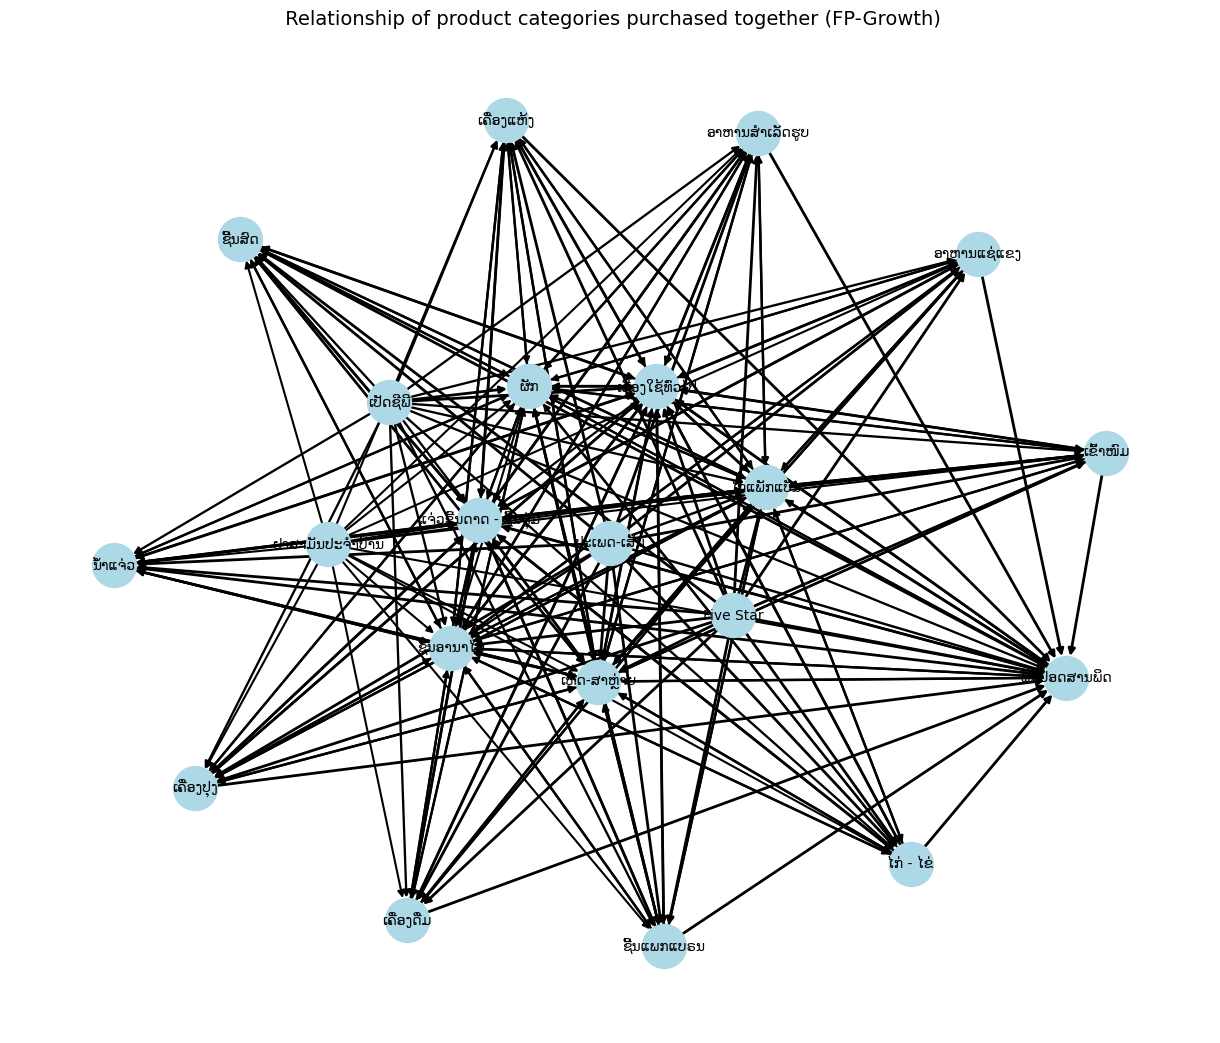

In [152]:

# ====== 9. Visualization ======
G = nx.DiGraph()
for _, row in rules.iterrows():
    for a in row['antecedents']:
        for c in row['consequents']:
            G.add_edge(str(a), str(c), weight=row['confidence'])

plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G, k=0.5)
edges = G.edges(data=True)
weights = [d['weight'] * 2 for (_, _, d) in edges]
nx.draw(G, pos, with_labels=True, node_size=1000, node_color="lightblue", font_size=10, arrows=True, width=weights)
plt.title(" Relationship of product categories purchased together (FP-Growth)", fontsize=14)
plt.show()


In [153]:
def recommend_next_items(items, rules, top_k=3):
    items = set(items)
    candidates = []

    for _, row in rules.iterrows():
        if items.issuperset(set(row["antecedents"])):
            candidates.append((list(row["consequents"])[0], row["confidence"]))

    # Sort by confidence
    candidates = sorted(candidates, key=lambda x: x[1], reverse=True)
    return [item for item, _ in candidates[:top_k]]

# Test the recommendation function:
print(" Recommend:", recommend_next_items(["ຜັກປອດສານພິດ", "ເປັດຊີພີ"], rules))


 Recommend: ['ນໍ້າແຈ່ວ', 'ນໍ້າແຈ່ວ', 'ຊີ້ນແພກແບຣນ']


In [154]:
tp = 0  # Predicted correctly
fp = 0  # Wrong prediction
fn = 0  # Don't predict but should predict

for _, row in rules.iterrows():
    antecedents = set(row["antecedents"])
    consequents = set(row["consequents"])

    for _, transaction in test_basket.iterrows():
        basket_items = set(test_basket.columns[transaction])
        if antecedents.issubset(basket_items):
            if consequents.issubset(basket_items):
                tp += 1
            else:
                fp += 1
        elif consequents.issubset(basket_items):
            fn += 1

precision = tp / (tp + fp) if tp + fp > 0 else 0
recall = tp / (tp + fn) if tp + fn > 0 else 0
f1 = 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0

print(f"\nPrecision: {precision:.2%}")
print(f"Recall: {recall:.2%}")
print(f"F1 Score: {f1:.2%}")



Precision: 81.67%
Recall: 41.41%
F1 Score: 54.96%


In [155]:
from mlxtend.frequent_patterns import association_rules

# rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.7)
top10_rules = rules.sort_values(by='confidence', ascending=False).head(10)


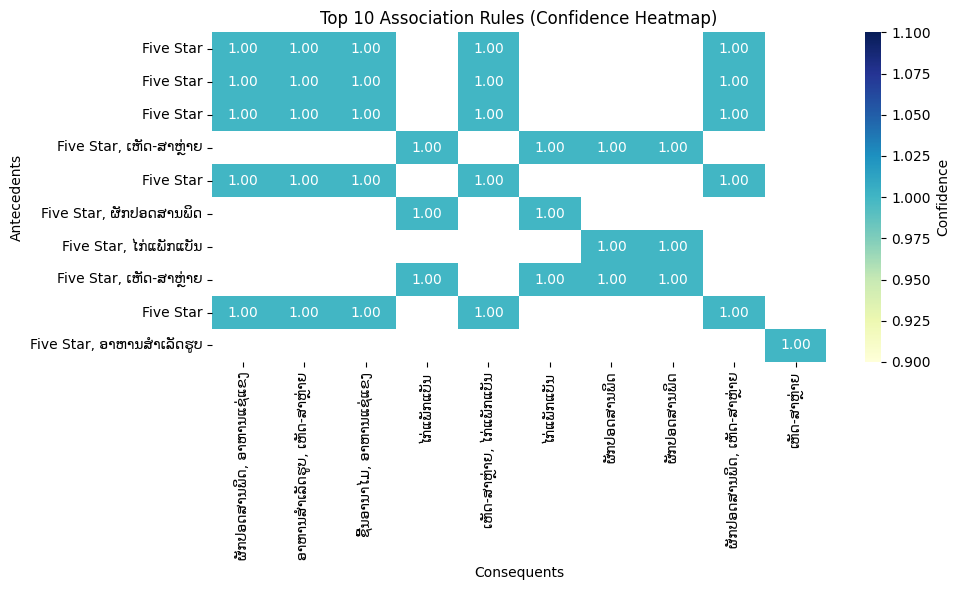

In [156]:
import seaborn as sns

# Convert names to be easy to read
def fs_to_str(fs):
    return ', '.join(sorted(fs))

top10_rules['antecedents_str'] = top10_rules['antecedents'].apply(fs_to_str)
top10_rules['consequents_str'] = top10_rules['consequents'].apply(fs_to_str)

# create  DataFrame for  heatmap
heatmap_df = pd.DataFrame(index=top10_rules['antecedents_str'],
                          columns=top10_rules['consequents_str'])

for _, row in top10_rules.iterrows():
    heatmap_df.loc[row['antecedents_str'], row['consequents_str']] = row['confidence']

# draw heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_df.astype(float), annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Confidence'})
plt.title("Top 10 Association Rules (Confidence Heatmap)")
plt.xlabel("Consequents")
plt.ylabel("Antecedents")
plt.tight_layout()
plt.show()


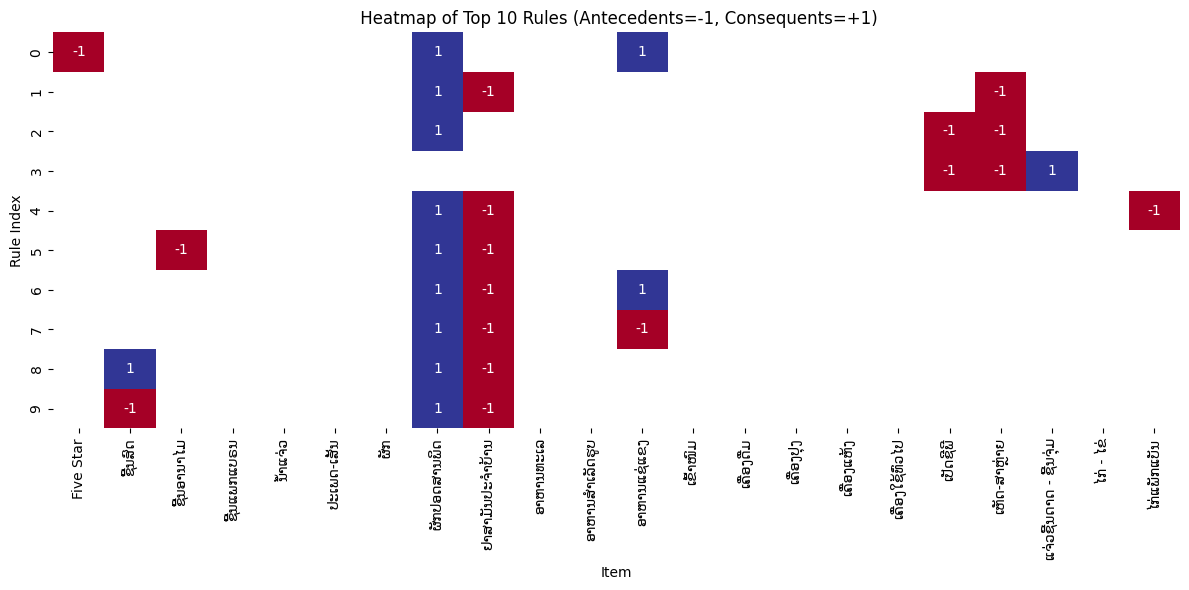

In [157]:
import numpy as np
import seaborn as sns

# Pull the Top 10 rules with the highest confidence
top_rules = rules.nlargest(10, 'confidence')

# สร้าง DataFrame สำหรับ Heatmap
heatmap_data = pd.DataFrame(0, index=range(10), columns=te.columns_)

for i, row in top_rules.iterrows():
    for item in row["antecedents"]:
        heatmap_data.loc[i, item] = -1  # use -1 instead antecedent
    for item in row["consequents"]:
        heatmap_data.loc[i, item] = 1   # use +1 instead consequent

# ✅ use np.nan instead None for not  dtype to  object
heatmap_data = heatmap_data.replace(0, np.nan)

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, annot=True, cmap="RdYlBu", center=0, cbar=False)
plt.title(" Heatmap of Top 10 Rules (Antecedents=-1, Consequents=+1)")
plt.xlabel("Item")
plt.ylabel("Rule Index")
plt.tight_layout()
plt.show()


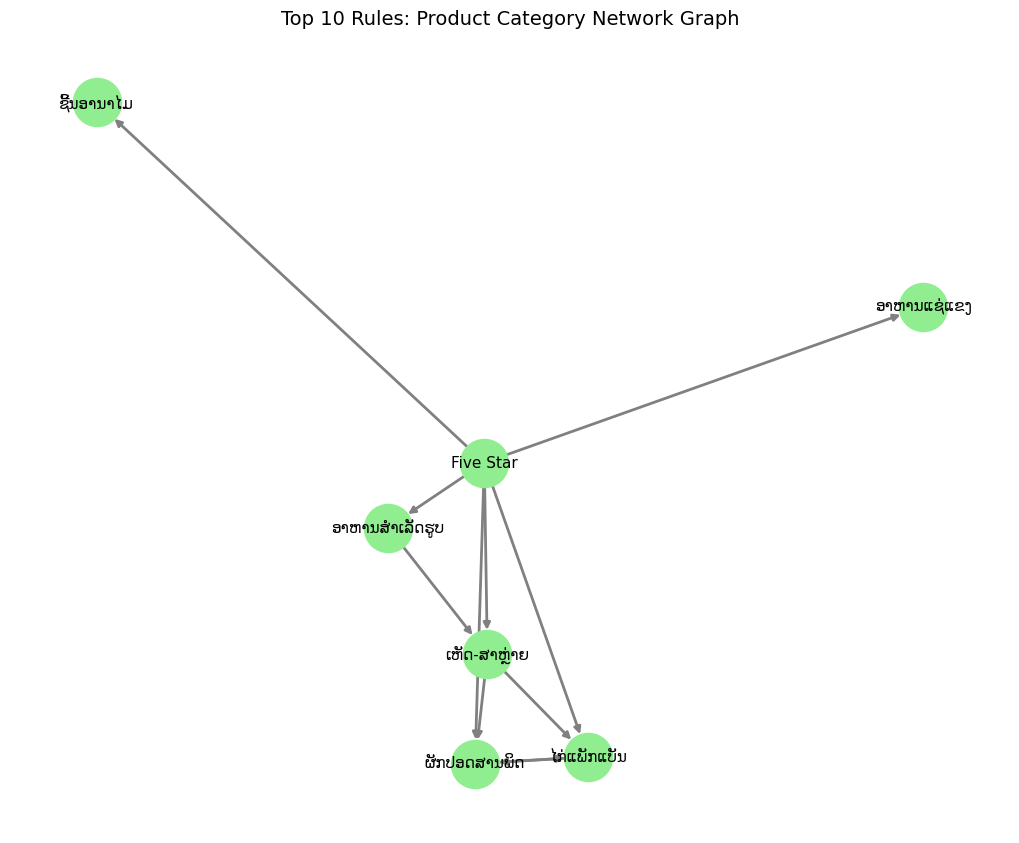

In [158]:
G = nx.DiGraph()
for _, row in top10_rules.iterrows():
    for a in row['antecedents']:
        for c in row['consequents']:
            G.add_edge(str(a), str(c), weight=row['confidence'])

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, k=0.5, seed=42)
edges = G.edges(data=True)
weights = [d['weight'] * 2 for (_, _, d) in edges]
nx.draw(G, pos, with_labels=True, node_size=1200, node_color="lightgreen",
        font_size=11, arrows=True, width=weights, edge_color="gray")
plt.title("Top 10 Rules: Product Category Network Graph", fontsize=14)
plt.show()


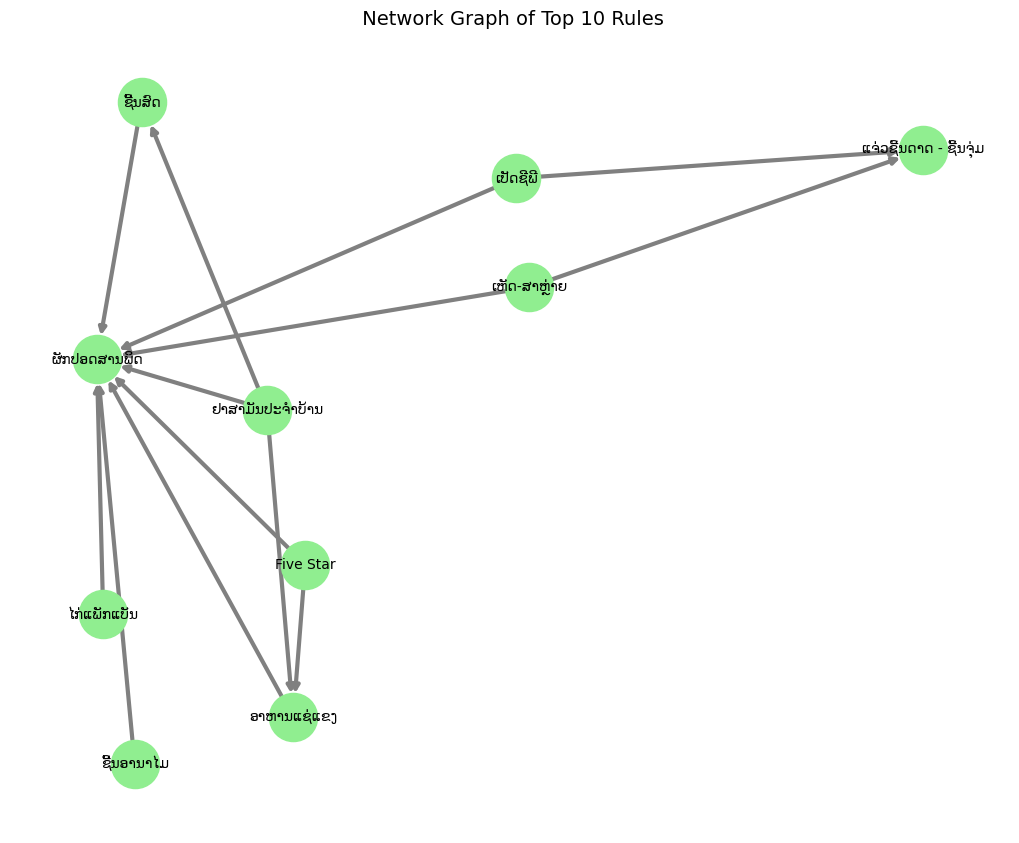

In [159]:
# use only  top 10 rules
top10_rules = rules.head(10)

G_top = nx.DiGraph()
for _, row in top10_rules.iterrows():
    for a in row['antecedents']:
        for c in row['consequents']:
            G_top.add_edge(str(a), str(c), weight=row['confidence'])

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G_top, k=0.7)
weights = [d['weight'] * 3 for (_, _, d) in G_top.edges(data=True)]
nx.draw(
    G_top, pos,
    with_labels=True,
    node_size=1200,
    node_color="lightgreen",
    font_size=10,
    arrows=True,
    width=weights,
    edge_color="gray"
)
plt.title(" Network Graph of Top 10 Rules", fontsize=14)
plt.show()


### Test2

Save file 

In [160]:
# rules['antecedents'] = rules['antecedents'].apply(list)
# rules['consequents'] = rules['consequents'].apply(list)
# rules.to_json("rules.json", orient="records", force_ascii=False)
